In [51]:
#%matplotlib nbagg
#%pylab
%matplotlib notebook

In [1]:
import pyspark

sc = pyspark.sql.SparkSession.Builder().getOrCreate()

## Levanto los archivos

In [2]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
points_recep = sc.read.json('datos/points-recep.jsonlines').rdd

## Utils

In [4]:
def remove_no_receptions(l):
    return list(filter(lambda e: e > 0, l))



### Cantidad de emisiones validas (con datos)

Text(0.5,0,'Cantidad de emisiones')

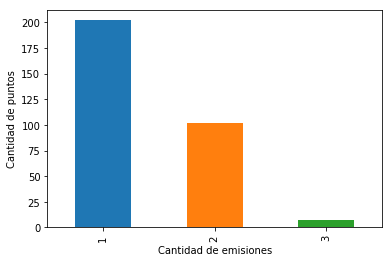

In [34]:
point_emissions = (
    points_recep
    .filter(lambda x: len(x['recep_0']+x['recep_1']+x['recep_2']+x['recep_3']))
    .groupBy(lambda x: x['Punto'])
    .map(lambda x: (x,len(list(x[1]))))
    .groupBy(lambda x: x[1])
    .map(lambda x: {'cant_emissions': x[0], 'cant_points': len(list(x[1]))})
)
p = pd.DataFrame(point_emissions.collect()).plot.bar(x='cant_emissions', y='cant_points', legend=False)
p.set_ylabel('Cantidad de puntos')
p.set_xlabel('Cantidad de emisiones')

### (2) Cantidad de recepciones por antena

Text(0.5,0,'Numero de antena')

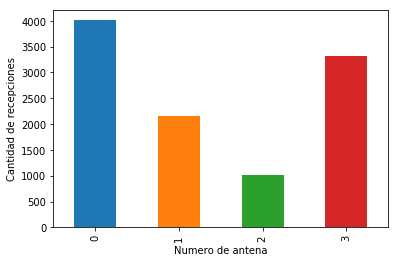

In [35]:
cants_recep_por_antena = []
for i in range(4):
    cant = points_recep.map(lambda x: len(x['recep_{}'.format(i)])).sum()
    cants_recep_por_antena.append({'antenna': i, 'cant_recep': cant})
    
p = pd.DataFrame(cants_recep_por_antena).plot.bar(x='antenna', y='cant_recep', legend=False)
p.set_ylabel('Cantidad de recepciones')
p.set_xlabel('Numero de antena')


### (3) Mean & Stdev de las recepciones de una misma emision

Text(0.5,0,'Numero de antena')

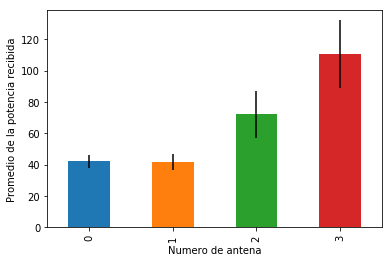

In [36]:
same_emisions_mean_and_std = []
for i in range(4):
    recep_field = 'recep_{}'.format(i)
    recepciones = points_recep.filter(lambda x: len(x[recep_field]) > 0).map(lambda x: x[recep_field])
    mean = recepciones.map(lambda x: np.mean(x)).mean()
    stdev = recepciones.map(lambda x: np.std(x)).mean()
    same_emisions_mean_and_std.append({'antenna': i, 'mean': mean, 'stdev': stdev})
    
p = pd.DataFrame(same_emisions_mean_and_std).plot.bar(x='antenna', y='mean', yerr='stdev', legend=False)
p.set_ylabel('Promedio de la potencia recibida')
p.set_xlabel('Numero de antena')


### Ejemplos distribucion de potencia de emisiones

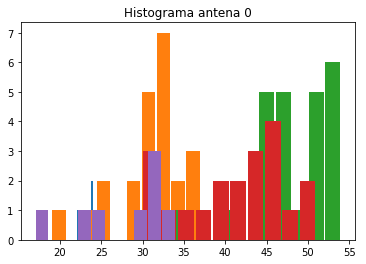

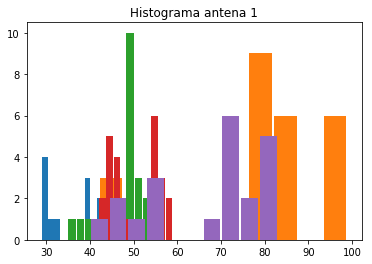

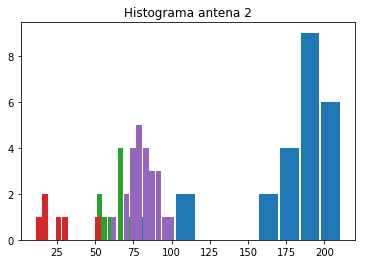

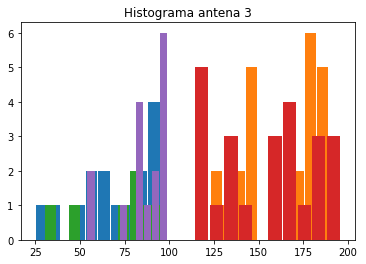

In [14]:

for i in range(4):
    recep_field = 'recep_{}'.format(i)
    recepciones = points_recep.filter(lambda x: len(x[recep_field]) > 0).map(lambda x: x[recep_field])
    l = recepciones.takeSample(False, 5)

    plt.figure()
    plt.title('Histograma antena {}'.format(i))
    for i in range(len(l)):
        plt.hist(l[i], rwidth=0.9)
    



### (4) Diferencia entre recepciones de un emisor en momentos distintos

### Ejemplos de distintas emisiones de un mismo punto

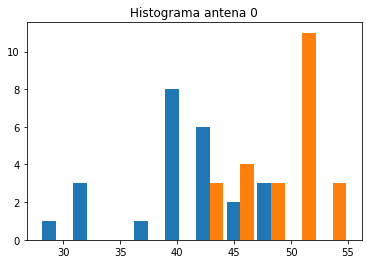

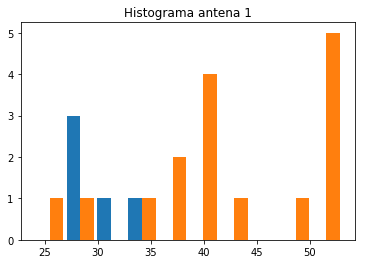

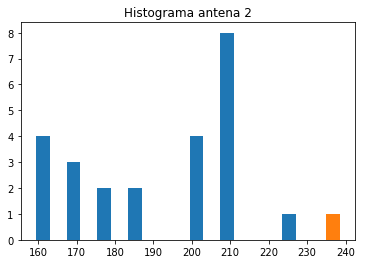

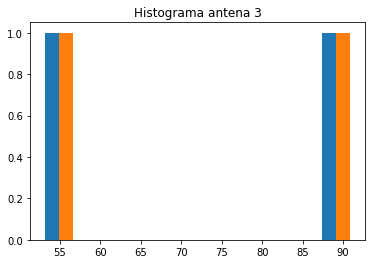

In [21]:
for i in range(4):
    recep_field = 'recep_{}'.format(i)
    points_with_many_emisions = points_recep.filter(lambda x: len(x[recep_field]) > 0).groupBy(lambda x: x['Punto']).filter(lambda x: len(x[1]) > 1)
    example = points_with_many_emisions.map(lambda x: [recep[recep_field] for recep in list(x[1])]).takeSample(False,1)
    plt.figure()
    plt.title('Histograma antena {}'.format(i))
    for i in range(len(example)):
        plt.hist(example[i], rwidth=0.9)
    
    

    
    


### (5) Variación de la potencia de las señales en funcion de la cantidad de señales recibidas

/Users/alew/py3/lib/python3.6/site-packages/pyspark/sql/session.py:366: UserWarning: Using RDD of dict to inferSchema is deprecated. Use pyspark.sql.Row instead
  warnings.warn("Using RDD of dict to inferSchema is deprecated. "


<IPython.core.display.Javascript object>


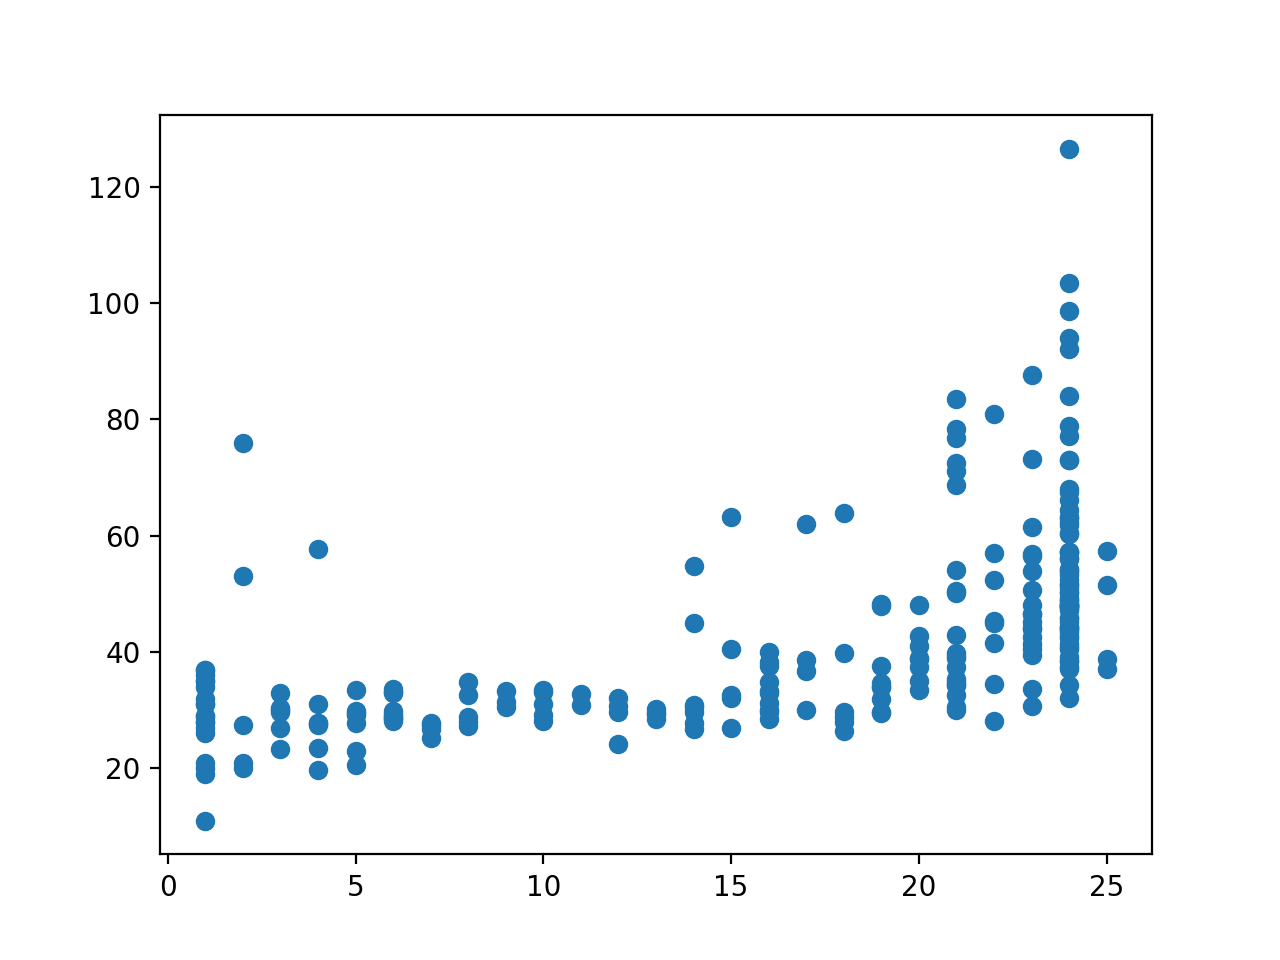

<IPython.core.display.Javascript object>


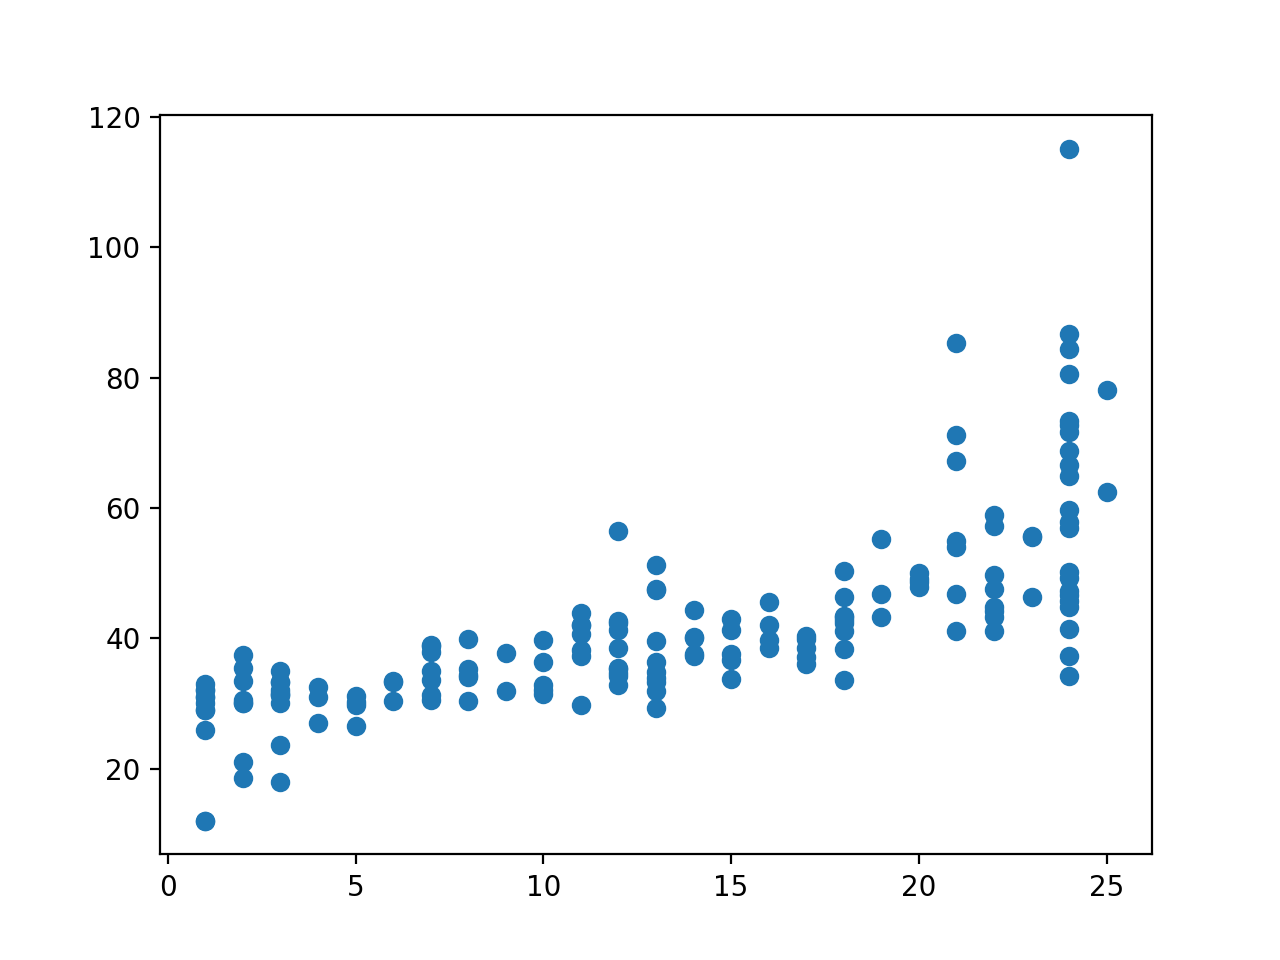

<IPython.core.display.Javascript object>


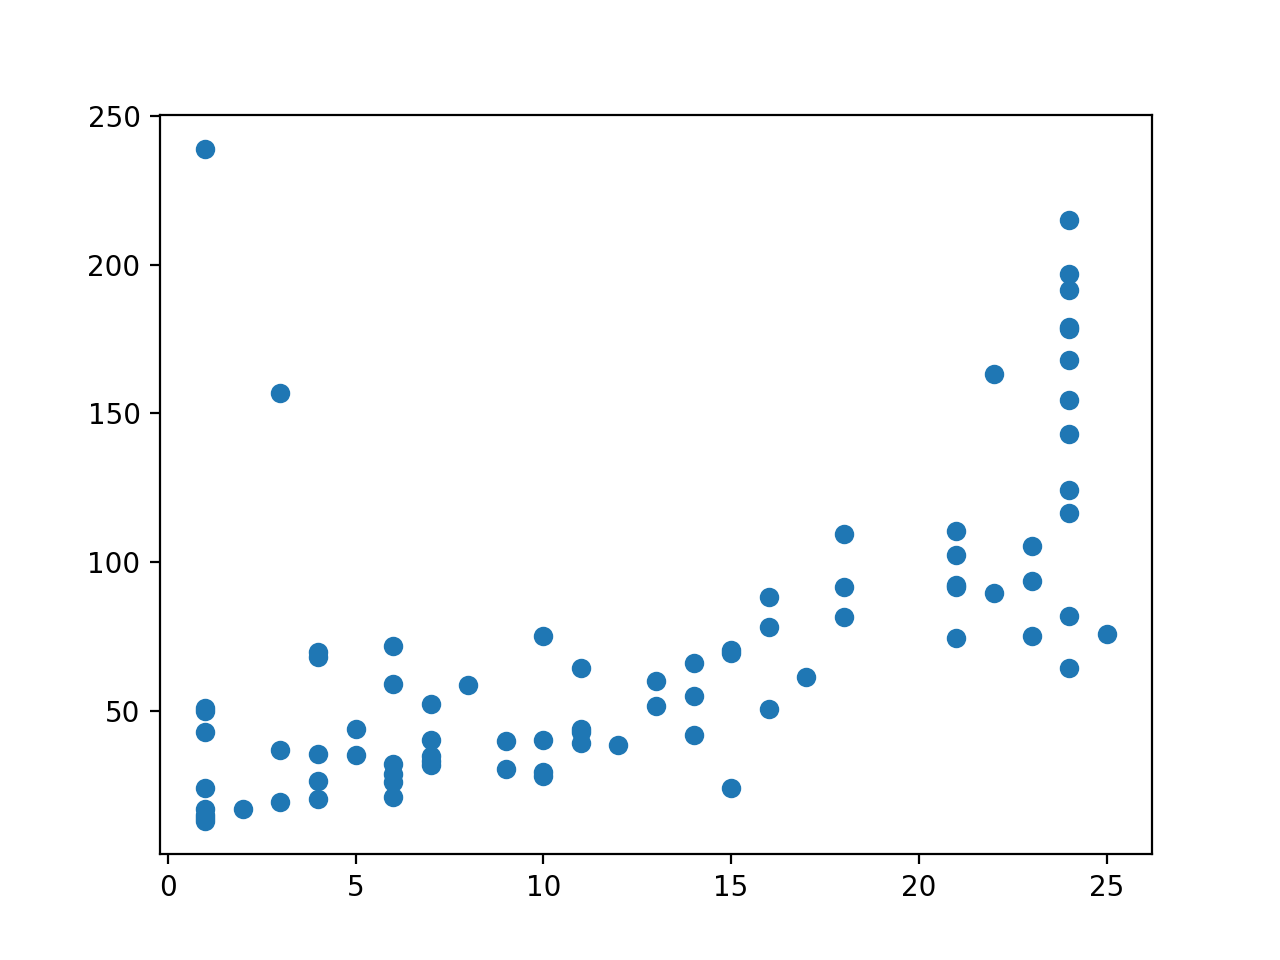

<IPython.core.display.Javascript object>


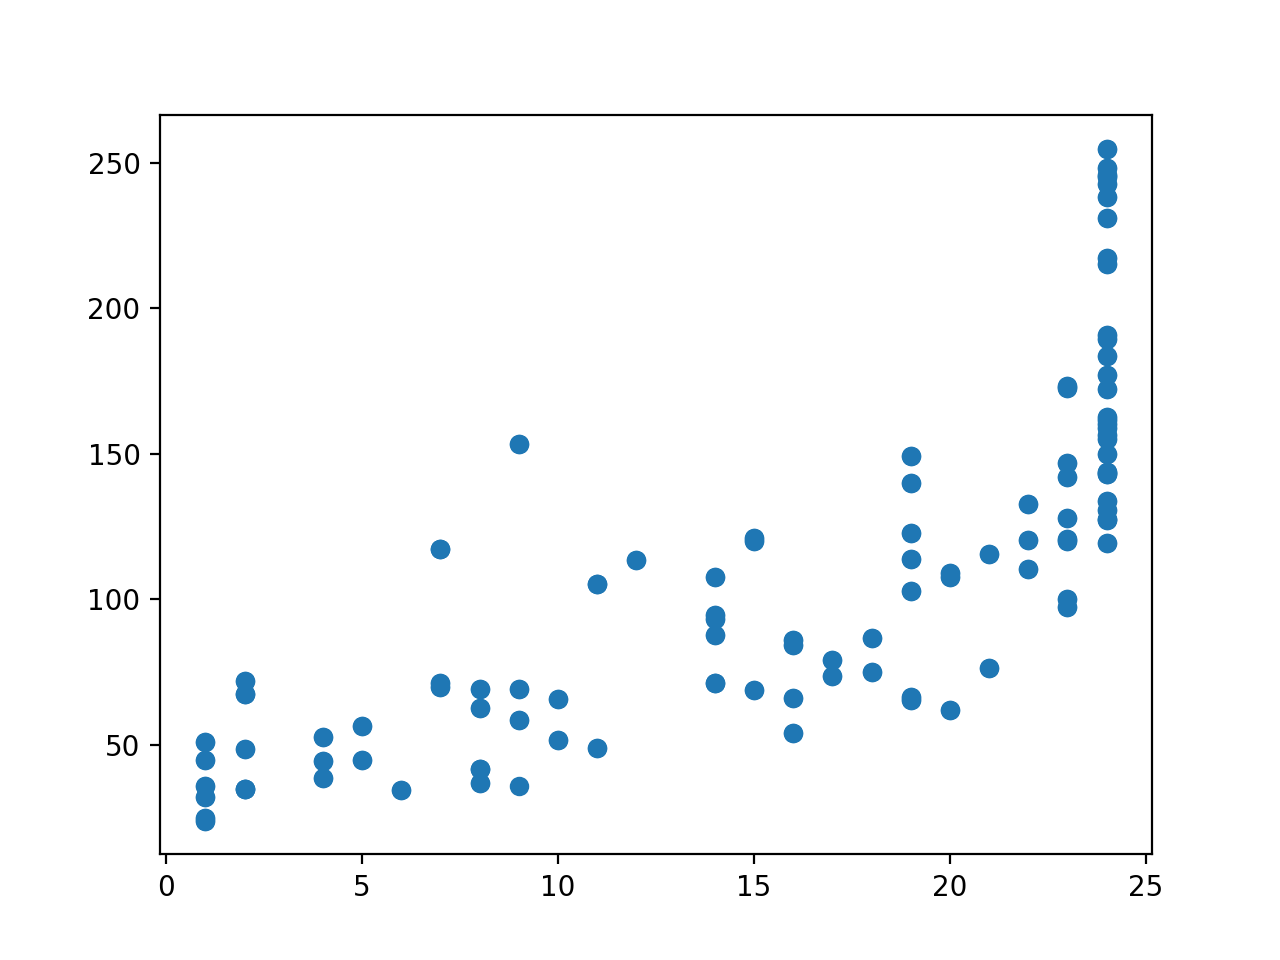

In [55]:
'''
for i in range(4):
    recep_field = 'recep_{}'.format(i)
    p = points_recep.filter(lambda x: len(x[recep_field]) > 0).map(lambda x: {'n': len(x[recep_field]),'mean': float(np.mean(x[recep_field]))}).toDF().toPandas()
    p.plot.scatter(x='n', y='mean')
    plt.title('Puntos calibracion en antena {}'.format(i))
'''

class DataBuilder:
    def __init__(self, something, data):
        self.data = data
        self.something = something
        self.cid = something.canvas.mpl_connect('button_press_event', self)
        self.ann = plt.annotate('', (0,0), (0, -20), xycoords='axes fraction', textcoords='offset points', va='top')

    def __call__(self, event):
        point = list(filter(lambda x: abs(x['n']-event.xdata) < 1 and abs(x['mean']-event.ydata) < 1, self.data))
        self.ann.remove()
        self.ann = plt.annotate(str(point), (0,0), (0, -20), xycoords='axes fraction', textcoords='offset points', va='top')
        
for i in range(4):
    recep_field = 'recep_{}'.format(i)
    p = points_recep.filter(lambda x: len(x[recep_field]) > 0).map(lambda x: {'Punto': x['Punto'],'n': len(x[recep_field]),'mean': float(np.mean(x[recep_field]))})
    p_pd = p.toDF().toPandas()
    fig, ax = plt.subplots()
    ax.scatter(p_pd['n'], p_pd['mean'])
    DataBuilder(fig, p.collect())
#    plt.show()




### (6) Mapa con colores con la intensidad de la señal recibida en cada antena por los puntos

In [22]:
posicion_antenas = [(464063.427327232,6110287.773965900), (464063.427327232,6110287.773965900), (464063.427327232,6110287.773965900), (464063.427327232,6110287.773965900)]
coordenadas_UTM = sc.read.csv('datos/DistancesCoordenadasUTM.csv', header=True, inferSchema=True).rdd



In [23]:
def calculate_avg_power(grouped_row, antena):
    signals = list(map(lambda x: x['recep_{}'.format(antena)], list(grouped_row[1])))
    signals_pd = pd.DataFrame([s for emision in signals for s in emision ])
    n = len(signals_pd)
    if n > 0:
        mean = float(signals_pd.mean()[0])
        stdev = float(signals_pd.std()[0])
    else:
        mean = 0
        stdev = 0
    return {
        'Punto': grouped_row[0],
        'mean': mean,
        'stdev': stdev,
        'n': n,
        'x': list(grouped_row[1])[0]['x'],
        'y': list(grouped_row[1])[0]['y']
    }


In [24]:
x_0 = 462385.503783397
x_f = 465958.114906211
y_0 = 6109042.35153865
y_f = 6112715.80637111

global x_0
global y_0

def normalize_positions(row):
    row['x'] = row['x']-x_0
    row['y'] = row['y']-y_0
    return row


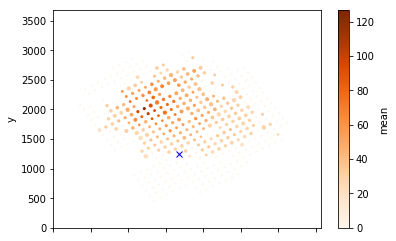

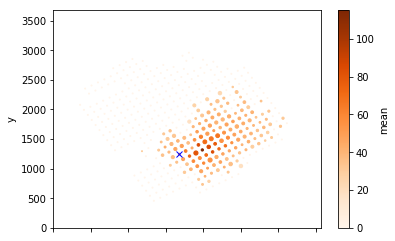

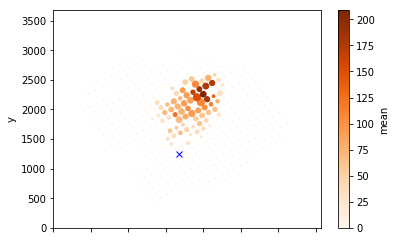

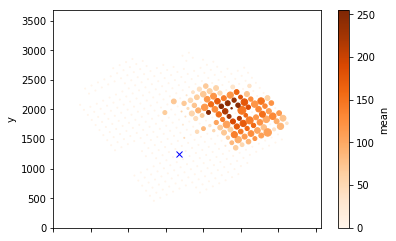

In [25]:

for antena in range(4):
    points_sig = points_recep.groupBy(lambda x:x['Punto']).map(lambda x: calculate_avg_power(x,antena)).map(normalize_positions)#.filter(lambda x: x['mean'] != 0)
    data = pd.DataFrame(points_sig.collect())
    ax = data.plot.scatter(x='x', y='y',c='mean',cmap='Oranges',s=data['stdev']+1)

    pos_antena = posicion_antenas[antena]
    ax.plot(pos_antena[0]-x_0, pos_antena[1]-y_0, "xb")
    plt.ylim(0,y_f-y_0)
    plt.xlim(0,x_f-x_0)

    

### Mapa con la cantidad de antenas usadas por punto

In [26]:
def calculate_amount_antennas_recep(grouped_row):
    signals = list(map(lambda x: [len(x['recep_{}'.format(i)])>0 for i in range(4)], list(grouped_row[1])))

    has_recep_by_antenna = np.array([False, False, False, False])
    for l in signals:
        has_recep_by_antenna = has_recep_by_antenna | np.array(l)

    return {
        'Punto': grouped_row[0],
        'cant': sum(has_recep_by_antenna),
        'x': list(grouped_row[1])[0]['x'],
        'y': list(grouped_row[1])[0]['y']
    }


(0, 3572.611122813949)

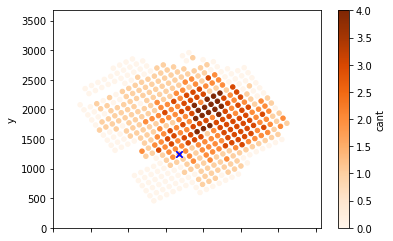

In [27]:
points_sig = points_recep.groupBy(lambda x:x['Punto']).map(calculate_amount_antennas_recep).map(normalize_positions)
ax = pd.DataFrame(points_sig.collect()).plot.scatter(x='x', y='y',c='cant',cmap='Oranges')

for i in range(4):
    pos_antena = posicion_antenas[i]
    ax.plot(pos_antena[0]-x_0, pos_antena[1]-y_0, "xb")
    
plt.ylim(0,y_f-y_0)
plt.xlim(0,x_f-x_0)

### Cantidad de puntos que usan _x_ cantidad de antenas

In [29]:
cant_recep = points_sig.groupBy(lambda x: x['cant']).map(lambda x: {'antennas': x[0],'cant_points': len(x[1])})

Text(0.5,0,'Cantidad de antenas')

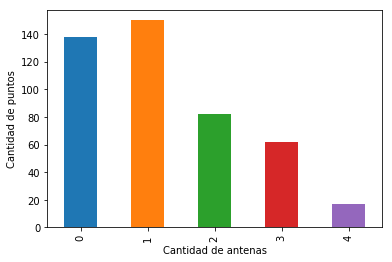

In [32]:
p = pd.DataFrame(cant_recep.collect()).plot.bar(x='antennas', y='cant_points', legend=False)
p.set_ylabel('Cantidad de puntos')
p.set_xlabel('Cantidad de antenas')

### (7) Distancia promedio de las antenas a los puntos

In [ ]:
import math
for antena in range(4):
    pos_antena = posicion_antenas[antena]
    mean_dist = coordenadas_UTM.map(lambda p: math.sqrt((pos_antena[0]-p['X'])**2+(pos_antena[1]-p['Y'])**2)).mean()
    print('mean distance to antenna {}: {}'.format(antena, mean_dist))

# Experimentos invalidos

### Las distintas emisiones de un mismo punto, tienen la misma distribucion?

In [ ]:
from scipy import stats

  
def ks_test(grouped_data, antenna):
    recep_field = 'recep_{}'.format(antenna)
    emisiones = list(filter(lambda x: len(x[recep_field]), list(grouped_data[1])))
    return (grouped_data[0], stats.ks_2samp(emisiones[0][recep_field], emisiones[1][recep_field]))

for i in range(4):
    recep_field = 'recep_{}'.format(i)
    print(recep_field)
    
    points_with_many_emisions = points_recep.filter(lambda x: len(x[recep_field]) > 0).groupBy(lambda x: x['Punto']).filter(lambda x: len(x[1]) > 1)
    ks_test_by_point = points_with_many_emisions.map(lambda x: ks_test(x, i)).sortBy(lambda x: x[1].pvalue)
    print('same distribution amount {}'.format(ks_test_by_point.filter(lambda x: x[1].pvalue > 0.05).count()))
    print('total items with more than one emision for antenna {} \n'.format(points_with_many_emisions.count()))

